In [85]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import util
import numpy as np
import heapq
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 

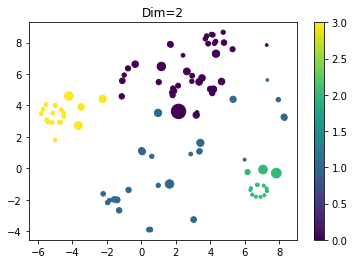

In [97]:
model = SentenceTransformer('all-MiniLM-L6-v2')

df = pd.read_csv('data/test.csv', header = 0, sep = ",")
answers = df.iloc[:,1]
student_id = df.iloc[:,0]
sentences = []
for answer in answers:
    sentences.append(answer)
bert_embeddings = model.encode(answers)
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3)
clustering_model.fit(bert_embeddings)
bert_label = clustering_model.labels_

df_clusters = pd.DataFrame({
    "id": student_id,
    "text": answers,
    "agg_bert_row": bert_label,
})

embedding_list = []
for i in bert_embeddings:
    embedding_list.append(i)


length = []
for i in range(0,len(student_id)):
    answer_length = len(answers[i])
    length.append(answer_length)
df_clusters["answer_length"] = length

X_embedded = TSNE(n_components=2).fit_transform(embedding_list)
vector_2 = pd.DataFrame(X_embedded)
df_clusters["x_position"] = vector_2.iloc[:,0]
df_clusters["y_position"] = vector_2.iloc[:,1]

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=length, c=bert_label)
plt.title("Dim=2")
plt.colorbar()
plt.show()

计算每一类类中心的向量

In [98]:
clusters = {}
groups = {}
for i in range(0,len(student_id)):
    i_cluster = bert_label[i]
    if i_cluster not in clusters:
        groups[i_cluster] = 1
        clusters[i_cluster] = bert_embeddings[i]
    else:
        groups[i_cluster] +=1
        clusters[i_cluster] = clusters[i_cluster] + bert_embeddings[i]
# center of the cluster       
for key in clusters:
    clusters[key] = clusters[key]/groups[key]

distant_point = {}
distant_point_id = {}
for i in range(0, len(student_id)):
    i_cluster = bert_label[i]
    cos_sim = util.cos_sim(bert_embeddings[i], clusters[i_cluster])
    if i_cluster not in distant_point:
        distant_point[i_cluster] = cos_sim
        distant_point_id[i_cluster] = i
    else:
        if(cos_sim < distant_point[i_cluster]):
            distant_point[i_cluster] = cos_sim
            distant_point_id[i_cluster] = i

influenced_points = {}
for key in distant_point_id:
    id = distant_point_id[key]
    if(distant_point[key]<0.85):
        key_vector = bert_embeddings[id]
        key_similarity_list = []
        for i in range(0,len(student_id)):
            cos_sim = util.cos_sim(bert_embeddings[id], bert_embeddings[i])
            key_similarity_list.append(cos_sim)
        influenced_points[key] = key_similarity_list

most_similar = {}
for key in influenced_points:
    max_index = []
    max_number = heapq.nlargest(6,influenced_points[key]) 
    for t in max_number:
        index = influenced_points[key].index(t)
        max_index.append(index)
        influenced_points[key][index] = 0
    most_similar[key] = max_index
dict = pd.DataFrame(pd.Series(most_similar))
dict = dict.reset_index().rename(columns={"index":"id"})
dict.columns=["id","most_similar_id"]


most_similar_answer = {}
for key in most_similar:
    similar_answers = []
    for i in most_similar[key]:
        similar_answer = answers[i]
        similar_answers.append(similar_answer)
    most_similar_answer[key] = similar_answers

dict2 = pd.DataFrame(pd.Series(most_similar_answer))
dict2 = dict2.reset_index().rename(columns={"index":"id"})
dict2.columns=["id","most_similar_answer"]

dict["most_similar_answer"] = dict2["most_similar_answer"]
types = []
for i in range(0, len(dict["id"])):
    types.append("3")
dict["type"] = types
dict.to_csv("cluster5.csv")

老师可以在这里选择调整距离

,id,most_similar_id,most_similar_answer,type
0,1,"[0, 68, 95, 41, 104, 64]","[Radical ideas , build off of other ideas, Bui...",1
1,3,"[1, 15, 25, 27, 31, 35]","[No judgement, Defer judgement, Defer Judgemen...",1
2,0,"[4, 16, 21, 38, 98, 10]","[Yes and, include all wild ideas too, Go for q...",1
3,5,"[61, 48, 8, 11, 23, 29]",[be visual; this is to say that human centered...,1
4,8,"[67, 24, 1, 65, 14, 43]","[No hate, Dont hate, just come up with ideas d...",1
5,4,"[74, 36, 20, 22, 99, 80]","[Consider fron the side of user, Know thy user...",1
